In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from lightgbm import LGBMRegressor, plot_importance
from mlforecast import MLForecast

from src.visualization.charts import ModelCharts
from src.visualization.metrics import PredictionEvaluator
from src.config import Config

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
config = Config()
variant_co2 = 'co2_per_capita'
train_df = pd.read_csv(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/train.csv')).rename(columns={'country_index': 'country'})
test_df = pd.read_csv(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/test.csv')).rename(columns={'country_index': 'country'})

with open(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/data_preprocessor_lightgbm.pkl'), 'rb') as f:
    data_preprocessor_lightgbm = pickle.load(f)

In [3]:
train_df

,year,country,population_lag_1,population_lag_2,gdp_lag_1,gdp_lag_2,temperature_change_from_co2_lag_1,temperature_change_from_co2_lag_2,cement_co2_lag_1,cement_co2_lag_2,...,coal_co2_lag_2,flaring_co2_lag_1,flaring_co2_lag_2,gas_co2_lag_1,gas_co2_lag_2,land_use_change_co2_lag_1,land_use_change_co2_lag_2,oil_co2_lag_1,oil_co2_lag_2,co2
0,1930,Argentina,0.007087,0.006943,0.174392,0.175266,0.493851,0.507331,0.022711,0.016325,...,0.048410,0.000000,0.000000,0.005904,0.003933,0.306015,0.311606,0.022659,0.022520,0.236081
1,1931,Argentina,0.007303,0.007176,0.162400,0.178610,0.481904,0.493851,0.024072,0.023836,...,0.047334,0.000000,0.000000,0.005711,0.005904,0.252516,0.306015,0.021200,0.022659,0.199768
2,1932,Argentina,0.007503,0.007394,0.146788,0.166327,0.471364,0.481904,0.033014,0.025265,...,0.045068,0.000000,0.000000,0.006939,0.005711,0.217711,0.252516,0.026236,0.021200,0.179355
3,1933,Argentina,0.007686,0.007595,0.138581,0.150338,0.462130,0.471364,0.030168,0.034650,...,0.037719,0.000000,0.000000,0.009276,0.006939,0.198031,0.217711,0.029199,0.026236,0.165318
4,1934,Argentina,0.007850,0.007779,0.142834,0.141933,0.454119,0.462130,0.030486,0.031663,...,0.033701,0.000000,0.000000,0.012256,0.009276,0.184591,0.198031,0.029855,0.029199,0.155812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,2003,Vietnam,0.059873,0.059659,0.070411,0.067622,0.070078,0.070801,0.153245,0.129113,...,0.020349,0.001236,0.001616,0.007499,0.004740,0.089355,0.093405,0.022043,0.019882,0.068187
3099,2004,Vietnam,0.060508,0.060292,0.075243,0.072114,0.069361,0.070078,0.171695,0.160839,...,0.022190,0.001445,0.001236,0.009425,0.007499,0.092293,0.089355,0.022477,0.022043,0.070668
3100,2005,Vietnam,0.061146,0.060932,0.080752,0.077062,0.068657,0.069361,0.186919,0.180204,...,0.025545,0.001409,0.001445,0.015698,0.009425,0.093135,0.092293,0.025559,0.022477,0.064508
3101,2006,Vietnam,0.061780,0.061573,0.086439,0.082705,0.067971,0.068657,0.215267,0.196182,...,0.027515,0.001344,0.001409,0.016666,0.015698,0.086350,0.093135,0.025280,0.025559,0.061692


## Hyperparameter optimization

In [4]:
def log_mape(y_true, y_pred):
    return np.mean(np.abs((np.log1p(y_true) - np.log1p(y_pred)) / np.log1p(y_true)))

In [5]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 30),
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        'num_threads': trial.suggest_int('num_threads', 1, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),

        #deal with overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 6.0, 10.0),

        #general params
        'verbosity': -1,
        'objective':'regression_l1',

    }

    # Initialize the LightGBM model
    model_optuna = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model_optuna = MLForecast(
        models=[model_optuna],
        freq=1,
        date_features=None,
        num_threads=2
    )

    # Perform cross-validation manually with dynamic horizons
    all_cv_predictions = []

    for country, country_data in train_df.groupby('country'):
        horizon = max(1, int(0.15 * len(country_data)))

        # Perform cross-validation for this country
        cv_predictions = forecast_model_optuna.cross_validation(
            df=country_data,
            h=horizon,
            n_windows=2,
            step_size=horizon//2,
            id_col='country',
            time_col='year',
            target_col='co2',
            static_features=[]
        )

        cv_predictions['country'] = country
        all_cv_predictions.append(cv_predictions)

    # Concatenate all predictions into a single DataFrame
    cv_predictions = pd.concat(all_cv_predictions).reset_index(drop=True)
    cv_predictions = cv_predictions.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
    cv_predictions = cv_predictions.dropna(subset=['co2_actual', 'co2_predicted'])

    log_mape_value = log_mape(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    return log_mape_value 

In [6]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-12-07 19:36:51,400] A new study created in memory with name: no-name-ee100545-125d-4f82-84be-6d4f7c726cf9
[I 2024-12-07 19:36:52,912] Trial 0 finished with value: 0.22677291690796206 and parameters: {'learning_rate': 0.05230461613314305, 'num_leaves': 50, 'min_data_in_leaf': 22, 'max_depth': 2, 'num_threads': 1, 'n_estimators': 30, 'bagging_fraction': 0.9973159595967223, 'feature_fraction': 0.8342224457169852, 'lambda_l1': 7.233978012475578, 'lambda_l2': 8.942539116054167}. Best is trial 0 with value: 0.22677291690796206.
[I 2024-12-07 19:36:54,926] Trial 1 finished with value: 0.22548191552836255 and parameters: {'learning_rate': 0.07435556917712438, 'num_leaves': 25, 'min_data_in_leaf': 25, 'max_depth': 4, 'num_threads': 3, 'n_estimators': 54, 'bagging_fraction': 0.838159883653838, 'feature_fraction': 0.9573221298591289, 'lambda_l1': 4.649100180904607, 'lambda_l2': 7.112510811416233}. Best is trial 1 with value: 0.22548191552836255.
[I 2024-12-07 19:36:57,846] Trial 2 finishe

Best Hyperparameters: {'learning_rate': 0.05519568249449247, 'num_leaves': 48, 'min_data_in_leaf': 10, 'max_depth': 2, 'num_threads': 5, 'n_estimators': 88, 'bagging_fraction': 0.9944537448342846, 'feature_fraction': 0.8166624497859691, 'lambda_l1': 6.854350416378871, 'lambda_l2': 7.308893734609929}


## Initialize the model

In [7]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    #**best_params,
    verbosity=-1,
    objective= 'regression_l1',
    metric= 'mae',
    is_unbalance= False,
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    date_features=None,
    num_threads=2
)

## Check feature importance

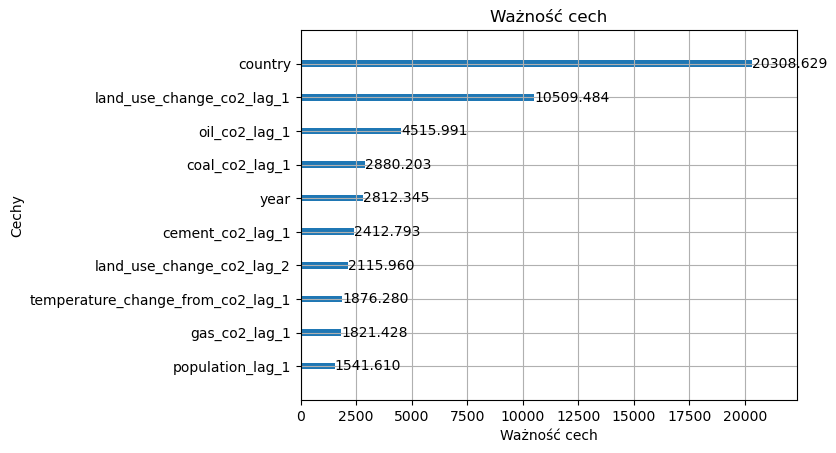

In [8]:
#Check feature importance
train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
ax = plot_importance(best_model, max_num_features=10, importance_type='gain')
ax.set_title('Ważność cech')
ax.set_xlabel("Ważność cech")
ax.set_ylabel("Cechy")
plt.show()

## Fit the model

In [9]:
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

forecast_model_path = os.path.join(config.models_folder, f'{variant_co2}_lightgbm_best_model.pkl')
with open(forecast_model_path, 'wb') as f:
    pickle.dump(forecast_model, f)

## Prediction on train data

In [10]:
fitted_values = forecast_model.forecast_fitted_values()
results_train = fitted_values.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

#predicted inverse transform
results_train_inverse = results_train.copy()

output_train_predicted = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_train_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_train_predicted, results_train.shape[0], train_df.shape[1]-2)
last_column_train_predicted = inverted_data_train_predicted[:, -1]
results_train_inverse['co2_predicted'] = last_column_train_predicted

output_train_actual = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_train_actual = data_preprocessor_lightgbm.inverse_transform_data(output_train_actual, results_train.shape[0], train_df.shape[1]-2)
last_column_train_actual = inverted_data_train_actual[:, -1]
results_train_inverse['co2_actual'] = last_column_train_actual

results_train_inverse.to_csv(os.path.join(config.predictions_lightgbm, f'{variant_co2}_test.csv'))

## Prediction on test data

In [11]:
all_predictions = []

for country in test_df['country'].unique():

    country_test_data = test_df[test_df['country'] == country].copy()
    horizon = country_test_data['year'].nunique()

    country_test_features = country_test_data.loc[:, country_test_data.columns != 'co2']

    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids=[country])

    country_predictions['country'] = country
    country_predictions['year'] = country_test_data['year'].values[:len(country_predictions)]
    country_predictions = country_predictions.merge(
        country_test_data[['year', 'co2']],
        on='year',
        how='left'
    ).rename(columns={'co2': 'co2_actual'})

    all_predictions.append(country_predictions)

results_test = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2_predicted'})

#predicted inverse transform
results_test_inverse = results_test.copy()

output_test_predicted = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_test_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_test_predicted, results_test.shape[0], test_df.shape[1]-2)
last_column_test_predicted = inverted_data_test_predicted[:, -1]
results_test_inverse['co2_predicted'] = last_column_test_predicted

output_test_actual = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_test_actual = data_preprocessor_lightgbm.inverse_transform_data(output_test_actual, results_test.shape[0], test_df.shape[1]-2)
last_column_test_actual = inverted_data_test_actual[:, -1]
results_test_inverse['co2_actual'] = last_column_test_actual

results_test_inverse.to_csv(os.path.join(config.predictions_lightgbm, f'{variant_co2}_train.csv'))

## Charts

In [12]:
charts = ModelCharts(results_train_inverse, results_test_inverse)

#Line plot
charts.generate_line_plot(variant = variant_co2, model_output_file=config.predictions_lightgbm)
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='train')
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='test')

#Scatter plot
charts.generate_scatter_plot(variant = variant_co2, model_output_file=config.predictions_lightgbm)
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='train')
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='test')

## Metrics

In [13]:
evaluator = PredictionEvaluator()
evaluator.evaluate(results_train_inverse, results_test_inverse, actual_col='co2_actual', predicted_col='co2_predicted', variant = variant_co2, model_output_file=config.metrics_lightgbm)

## Prepare residuals to hybrid model

In [14]:
#Train data
residuals_train_df = results_train_inverse[['country', 'year']].copy()  # Include necessary columns
residuals_train_df['residual'] = results_train_inverse['co2_actual'] - results_train_inverse['co2_predicted']
residuals_train_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'lightgbm_lstm/{variant_co2}/residuals_train.csv'), index=False)

In [15]:
#Test data
residuals_test_df = results_test_inverse[['country', 'year']].copy()  # Include necessary columns
residuals_test_df['residual'] = results_test_inverse['co2_actual'] - results_test_inverse['co2_predicted']
residuals_test_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'lightgbm_lstm/{variant_co2}/residuals_test.csv'), index=False)